#Task 1: Data Handling

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import kagglehub
from dotenv import load_dotenv
import os
load_dotenv()



True

**Load Dataset**

In [23]:
csv_file = 'apartments_for_rent_classified_10K.csv'

print(csv_file, ':CSV FILE')

df = pd.read_csv(csv_file, encoding='latin1', sep=';', on_bad_lines='skip')

# Check first rows
df.head()

# Check info
df.info()


apartments_for_rent_classified_10K.csv :CSV FILE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10000 non-null  int64  
 1   category       10000 non-null  object 
 2   title          10000 non-null  object 
 3   body           10000 non-null  object 
 4   amenities      6451 non-null   object 
 5   bathrooms      9966 non-null   float64
 6   bedrooms       9993 non-null   float64
 7   currency       10000 non-null  object 
 8   fee            10000 non-null  object 
 9   has_photo      10000 non-null  object 
 10  pets_allowed   5837 non-null   object 
 11  price          10000 non-null  int64  
 12  price_display  10000 non-null  object 
 13  price_type     10000 non-null  object 
 14  square_feet    10000 non-null  int64  
 15  address        6673 non-null   object 
 16  cityname       9923 non-null   object 
 17  st

**Handling Missing Values**

In [24]:
# Fill numeric missing values
df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
df['bedrooms'].fillna(df['bedrooms'].median(), inplace=True)
df['latitude'].fillna(df['latitude'].median(), inplace=True)
df['longitude'].fillna(df['longitude'].median(), inplace=True)

# Fill categorical missing
df['pets_allowed'].fillna('Unknown', inplace=True)
df['cityname'].fillna('Unknown', inplace=True)
df['state'].fillna('Unknown', inplace=True)

C:\Users\winst\AppData\Local\Temp\ipykernel_45168\3277597175.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
C:\Users\winst\AppData\Local\Temp\ipykernel_45168\3277597175.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

**Feature Selection & Encoding**

In [25]:
# Drop irrelevant and high-cardinality columns
drop_cols = ['id', 'title', 'body', 'amenities', 'price_display', 'source', 'time', 'address', 'cityname', 'state']
df.drop(columns=drop_cols, inplace=True)

# Encode only low-cardinality categorical variables
categorical_cols = ['category', 'currency', 'price_type', 'has_photo', 'pets_allowed']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


**Split Feaatures & Target**

In [26]:
# 1. Separate features and target
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

# 2. Identify any remaining object columns (should be none ideally)
object_cols = X.select_dtypes(include=['object']).columns
print("Remaining object columns:", object_cols)

# 3. If any object columns remain, apply one-hot encoding
if len(object_cols) > 0:
    X = pd.get_dummies(X, columns=object_cols, drop_first=True)

# 4. Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Standardize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Shapes:", X_train_scaled.shape, X_test_scaled.shape)


Remaining object columns: Index(['fee'], dtype='object')
Shapes: (8000, 14) (2000, 14)


In [27]:
# Save feature names for later use in API
feature_names = X_train.columns.tolist()
import joblib
joblib.dump(feature_names, 'feature_names.pkl')
print("Saved feature names:", feature_names)

Saved feature names: ['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude', 'category_housing/rent/home', 'category_housing/rent/short_term', 'price_type_Monthly|Weekly', 'price_type_Weekly', 'has_photo_Thumbnail', 'has_photo_Yes', 'pets_allowed_Cats,Dogs', 'pets_allowed_Dogs', 'pets_allowed_Unknown']


**Gradient Descent Linear Regression Implementation**

MSE Gradient Descent Linear Regression: 1112227.3259396385


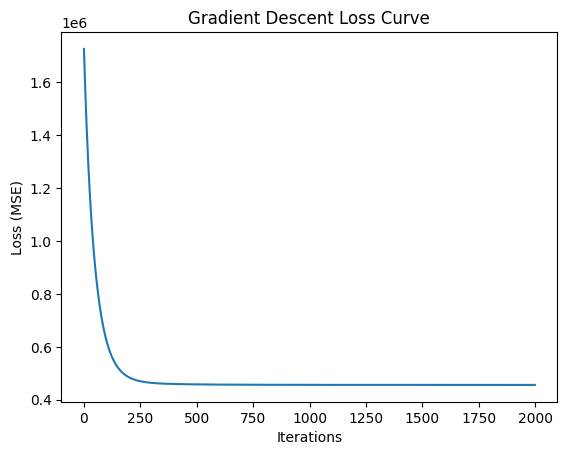

In [28]:
class GradientDescentLinearRegression:
    def __init__(self, lr=0.01, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.loss_history = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for i in range(self.n_iters):
            y_predicted = np.dot(X, self.weights) + self.bias
            # Compute gradients
            dw = (1/n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1/n_samples) * np.sum(y_predicted - y)
            # Update weights
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            # Compute loss
            loss = (1/(2*n_samples)) * np.sum((y_predicted - y)**2)
            self.loss_history.append(loss)

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

# Train Gradient Descent Linear Regression
gd_lr = GradientDescentLinearRegression(lr=0.01, n_iters=2000)
gd_lr.fit(X_train_scaled, y_train)
y_pred_gd = gd_lr.predict(X_test_scaled)
mse_gd = mean_squared_error(y_test, y_pred_gd)
print("MSE Gradient Descent Linear Regression:", mse_gd)

# Plot loss curve
plt.plot(gd_lr.loss_history)
plt.title("Gradient Descent Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss (MSE)")
plt.show()

Standard Linear Regression

In [29]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)
print("MSE Linear Regression (sklearn):", mse_lr)

MSE Linear Regression (sklearn): 1123269.915153535


Decision Tree Regressor

In [30]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)
mse_dt = mean_squared_error(y_test, y_pred_dt)
print("MSE Decision Tree:", mse_dt)

MSE Decision Tree: 388945.3387568282


 Random Forest Regressor

In [31]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("MSE Random Forest:", mse_rf)

MSE Random Forest: 219446.66059274192


**Scatter Plot: Predicted vs Actual**

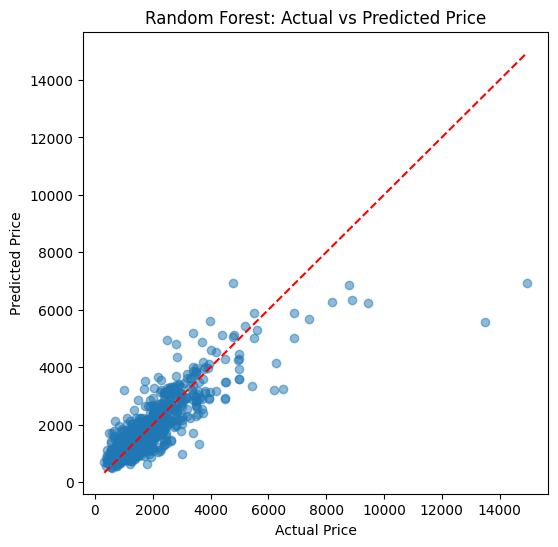

In [32]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Random Forest: Actual vs Predicted Price")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

**Save Best Model + Scaler**

In [33]:
best_model = rf
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']